In [11]:
from openai import OpenAI
from dotenv import load_dotenv
from multiprocessing import Pool
import os
import time
import pickle
import json
from tqdm import tqdm
import csv
import numpy as np
from utils import load_instances, load_labels, load_annotator_labels
import pickle 
from collections import defaultdict
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import f1_score, confusion_matrix
import seaborn
import matplotlib.pyplot as plt

load_dotenv()
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"], organization="org-6u1yKGMuXAyb3dStdjvmFHMo")

Since running the prompts through chatgpt are ran through multiprocessing, this `ipynb` will only run metrics on saved prompt files.

In [6]:
response_files = [('gpt3.5', 'data/gpt3.5_answers_qa.pkl'), ('gpt4', 'data/gpt4_answers_qa.pkl')]

In [7]:
for model_name, file in response_files:
    with open(file, 'rb') as fp:
            chatgpt_answers = pickle.load(fp)
        
    count = 0
    total_count = 0
    for para_lst in chatgpt_answers:
        for response in para_lst:
            if response["response"] != "1" and response["response"] != "0":
                print("error")
            elif response["response"] == response["label"]:
                count += 1
            
            total_count += 1
    print(f"{model_name} accuracy: {count / total_count}") 

gpt3.5 accuracy: 0.5866747060596925
gpt4 accuracy: 0.26


In [8]:
def get_id_to_target_word():
    instances = load_instances()
    
    id_target_dict = {}
    for instance in instances:
        id_target_dict[instance["id"]] = instance["word"]
    
    return id_target_dict

In [9]:

ids_to_word = get_id_to_target_word()
annotator_labels = load_annotator_labels()

for model_name, file in response_files:

    with open(file, 'rb') as fp:
        chatgpt_answers = pickle.load(fp)

    meaning_change = defaultdict(list)

    for para_lst in chatgpt_answers:
        for response in para_lst:
            target_word = ids_to_word[response["id"]]
            if response["response"] != "1" and response["response"] != "0":
                print("error")
            else:
                meaning_change[target_word].append(int(response["response"]))

    mc_dict = {}
    for key in list(meaning_change.keys()):
        mc_dict[key] = np.mean(np.asarray(meaning_change[key]))

    

    gpt_vec = []
    annotator_vec = []

    for key in annotator_labels.keys():
        gpt_vec.append(float(mc_dict[key]))
        annotator_vec.append(float(annotator_labels[key]))


    pearson, p_value = pearsonr(gpt_vec, annotator_vec)
    print(f"{model_name} pearson corr: {pearson}, p-value: {p_value}")

gpt3.5 pearson corr: -0.16726689817294357, p-value: 0.3443892890379424
gpt4 pearson corr: 0.6866484682666557, p-value: 7.324716289807194e-06


gpt3.5 f1: 0.011535688536409516
gpt4 f1: 0.38333333333333336


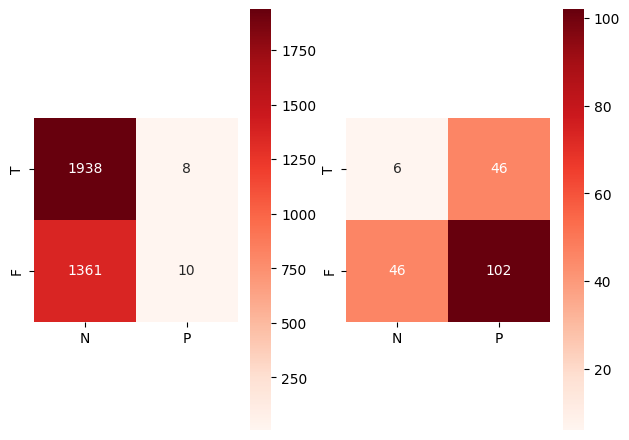

In [23]:
#f1 not a good metric as we have a lot more true negatives

confusion_mats = np.zeros((2, 2, 2))
for i, (model_name, file) in enumerate(response_files):

    with open(file, 'rb') as fp:
        chatgpt_answers = pickle.load(fp)

    response_list = []
    label_list = []

    for para_lst in chatgpt_answers:
        for response in para_lst:
            label_list.append(response["label"])
            response_list.append(response["response"])

    f1 = f1_score(label_list, response_list, average="binary", pos_label="1")
    print(f"{model_name} f1: {f1}")

    cm = confusion_matrix(label_list, response_list)
    cm[0, 1], cm[1, 1] = cm[1, 1], cm[0, 1]
    confusion_mats[i] = cm


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()

ax1.set_title("GPT3.5")
ax2.set_title("GPT4")

seaborn.heatmap(confusion_mats[0], xticklabels='NP', yticklabels='TF', ax=ax1, annot=True, square=True, cmap='Reds', fmt='g')
seaborn.heatmap(confusion_mats[1], xticklabels='NP', yticklabels='TF', ax=ax2, annot=True, square=True, cmap='Reds', fmt='g')
plt.savefig("confusion_mat")
    